In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from stochastic_processes import (
    get_spectrum,
    NoiseGenerator,
    Over_f_noise,
    OU_noise,
)

# Simulation parameters
N_STEPS = 100_000
DT = 0.001
N_FLUCTUATORS = 40
S1 = 1.0
ommax = 2 * np.pi / (2 * DT)   # angular freq ~ Nyquist
ommin = 2 * np.pi / (N_STEPS * DT)
sigma_couplings = 0.0
equally_dist = True

gen = NoiseGenerator(dt=DT)

# Over_f_noise instance: trajectory, ideal_spectrum, and gammas/sigmas for JAX
over_f = Over_f_noise(
    n_fluctuators=N_FLUCTUATORS,
    S1=S1,
    sigma_couplings=sigma_couplings,
    ommax=ommax,
    ommin=ommin,
    fluctuator_class=OU_noise,
    equally_dist=equally_dist,
)

In [2]:
# 1) IFFT method (fast, for comparison)
start = time.time()
noise_ifft = gen.generate_1f_ifft(N_STEPS)
print(f"IFFT: {time.time() - start:.4f} s")

# 2) NumPy OU (Over_f_noise)
times = np.full(N_STEPS, DT)
start = time.time()
trajectory = np.array(over_f.gen_trajectory(times))
trajectory = trajectory / np.std(trajectory)
print(f"Over_f_noise (NumPy): {time.time() - start:.4f} s")

# 3) JAX OU (same gammas/sigmas as over_f for comparable spectrum)
gammas = np.array([f.tc**-1 for f in over_f.fluctuators])
sigmas = np.array([f.sigma for f in over_f.fluctuators])
_ = gen.generate_ou_jax(10, gammas, sigmas, seed=43)  # warmup
start = time.time()
noise_jax = gen.generate_ou_jax(N_STEPS, gammas, sigmas, seed=42)
print(f"JAX OU: {time.time() - start:.4f} s")

IFFT: 0.0056 s
Over_f_noise (NumPy): 9.8955 s
JAX OU: 0.2490 s


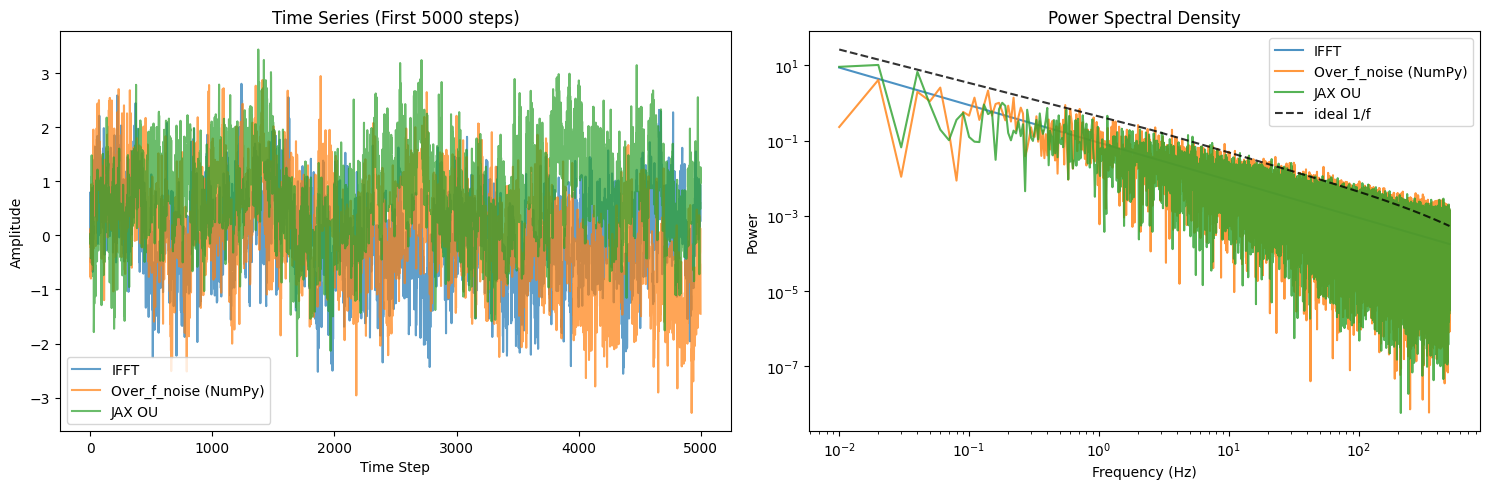

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
slice_idx = 5000
total_time = N_STEPS * DT

# Time series (first 5000 steps)
ax1.plot(noise_ifft[:slice_idx], label="IFFT", alpha=0.7)
ax1.plot(trajectory[:slice_idx], label="Over_f_noise (NumPy)", alpha=0.7)
ax1.plot(noise_jax[:slice_idx], label="JAX OU", alpha=0.7)
ax1.set_title("Time Series (First 5000 steps)")
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Amplitude")
ax1.legend()

# Spectra
def plot_spectrum(signal, label, ax):
    f, Sxx = get_spectrum(signal, DT, total_time)
    ax.loglog(f[1:], Sxx[1:], label=label, alpha=0.8)

plot_spectrum(noise_ifft, "IFFT", ax2)
plot_spectrum(trajectory, "Over_f_noise (NumPy)", ax2)
plot_spectrum(noise_jax, "JAX OU", ax2)
oms = 2 * np.pi * np.linspace(1 / total_time, 1 / (2 * DT), 200)
ax2.loglog(oms / (2 * np.pi), over_f.ideal_spectrum(oms), "k--", label="ideal 1/f", alpha=0.8)
ax2.set_title("Power Spectral Density")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Power")
ax2.legend()
plt.tight_layout()
plt.show()